In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src')
import utils

# Machine Learning Models

Many problems in machine learing seek to build a model

$$g(a; x) \approx y$$

given a data set

$$\{(a_1, y_1), \dots, (a_m, y_m)\},$$

with components
* $a_i \in \mathbf{R}^n$ - data features,
* $y_i \in \mathbf{R}$ or $\{0, 1\}$ - data value or class,
* $g: \mathbf{R}^n \to \mathbf{R}$ or $\{0, 1\}$ - prediction function,
* $x \in \mathbf{R}^n$ - model parameters,
* $m$ - number of data points, and
* $n$ - number of data features.

We can fit a model to the given data by solving an optimization problem of the form

$$\min_x \sum_{i=1}^m f_i(g(a_i; x), y_i) + r(x)$$

with components
* $x \in \mathbf{R}^n$ - model parameters,
* $f_i: \mathbf{R}^n \to \mathbf{R}$ - functions that measure how well the model fits the data for a given set of parameters, and
* $r(x): \mathbf{R}^n \to \mathbf{R}$ - regularization function.

# Logistic Regression

In the logistic regression problem, we would like to find a linear predictor

$$g(a_i; x) = x_1 a_{i1} + \dots + x_n a_{in} = a_i^Tx \approx \begin{cases} \text{positive} & \Rightarrow \quad y_i = 1, \\ \text{negative} & \Rightarrow \quad y_i = 0, \end{cases}$$

where $a_i$ are continuous data features and $y_i \in \{0, 1\}$ are discrete class labels.
One approach for deriving the [loss functions](https://en.wikipedia.org/wiki/Loss_function) $f_i$ is to combine the [Bernoulli model](https://en.wikipedia.org/wiki/Bernoulli_distribution) with a linear predictor, and then develop a [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) formulation.
Let $p_i$ be the probability that observation $i$ belongs to class 1.
We begin by writing the probability mass function for an observation $(a_i, y_i)$ given model parameters $x$ in standard form:

\begin{align}
p((a_i, y_i); x) &= p_i^{y_i} (1 - p_i)^{1 - y_i} \\
&= \exp\big( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \big) \\
&= \exp\left( y_i \log\left(\frac{p_i}{1 - p_i}\right) + \log(1 - p_i) \right)
\end{align}

Next, we assume that the term multiplied by $y_i$, the [log-odds](https://en.wikipedia.org/wiki/Logit) of observation $i$ belonging to class 1, can be approximated with our linear predictor:

$$\log\left(\frac{p_i}{1 - p_i}\right) \approx a_i^Tx$$

Substituting this into our probability above, the PMF of all $m$ i.i.d. observations is

\begin{align}
p\big(\{(a_1, y_1), \dots, (a_m, y_m)\}; x\big) &= \prod_{i=1}^m p((a_i, y_i); x) \\
&= \prod_{i=1}^m \exp\big(y_i a_i^Tx - \log\left(1 + \exp(a_i^Tx)\right) \big) \\
&= \exp\left(\sum_{i=1}^n y_i a_i^Tx - \log\left( 1 + \exp(a_i^Tx) \right) \right).
\end{align}

Alternatively, we can consider the likelihood of a set of model parameters given our $m$ observations,

$$\mathcal{L}\big(x; \{(a_1, y_1), \dots, (a_m, y_m) \} \big) = p\big(\{(a_1, y_1), \dots, (a_m, y_m)\}; x\big),$$

so that we can solve an optimization problem to find the parameters with the maximum likelihood.
In practice, this is often done by minimizing the negative log-likelihood, which results in our logistic regression problem

$$\min_x \sum_{i=1}^m \log\big( 1 + \exp(a_i^Tx) \big) - y_i a_i^T x.$$

After solving for the model parameters, we can predict the class labels of new data using the sign of the linear predictor,

$$g(a_i; x) = \begin{cases} 1 & \text{if} \quad a_i^Tx \geq 0, \\ 0 & \text{if} \quad a_i^T < 0, \end{cases}$$

or we can approximate the probability of an observation belonging to class 1,

$$P(y_i = 1 | a_i, x) = \frac{\exp(a_i^Tx)}{1 + \exp(a_i^Tx)} = \frac{1}{1 + \exp(-a_i^Tx)},$$

where the [logistic model](https://en.wikipedia.org/wiki/Logistic_function) follows from our linear approximation of the log-odds.

# Outlier Detection/Removal via Trimming

[Outliers](https://en.wikipedia.org/wiki/Outlier) in the training data can sometimes make it difficult to find a good predictor.
These problematic points can come from many causes, such as malfunctioning sensors, fraudulent behavior, natural population variation, or even erroneus model assumptions.
One way to identify and remove outliers during the optimization proces is to add auxiliary weights to each training example, called [trimming](https://en.wikipedia.org/wiki/Least_trimmed_squares):

$$min_{x, w} \sum_{i=1}^m w_k f_i(x) \quad \text{s.t.} \quad w_i \in [0, 1], \quad \sum_{i=1}^m w_i = h$$

For a fixed $x$, the $h$ training examples with the smallest residuals will be classified as inliers ($w_i = 1$), while the remaining $m - h$ points will be classified as outliers ($w_i = 0)$.
Because the outliers have small weights, they do not influence the final solution.
Here $h$ is a hyperparameter representing the the number of inliers we expect in the training data.

This problem is now nonconvex, but we can still find a good solution using variations of the optimization methods we've seen before.
Here, our solver alternates between updating $x$ using a step of [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) and updating $w$ using a step of [projected gradient descent](https://en.wikipedia.org/wiki/Proximal_gradient_methods_for_learning).

# Exercise 1: Simple Example

In the example below, experiment with the noise_level and inlier_pct variables to answer the following questions:
* Let inlier_pct = 1.0. Using noise_level = 0, 0.1, 0.25, and 0.5, how does the presence of outliers affect the shape of the classifier and its ability to predict class labels?
* Let noise_level = 0.25. Using inlier_pct = 1.0, 0.98, 0.96, 0.94, 0.92, and 0.9. How does the number of outliers detected affect the shape of the classifier and its ability to predict class labels?
* Play around with other parameter values to see how the presence of outliers and the ability to detect them changes the quality of the classifier.

Correctly classified in training set: 50/50
True x: [-10, 2], Classifier: [-9.10430803  1.85533956]


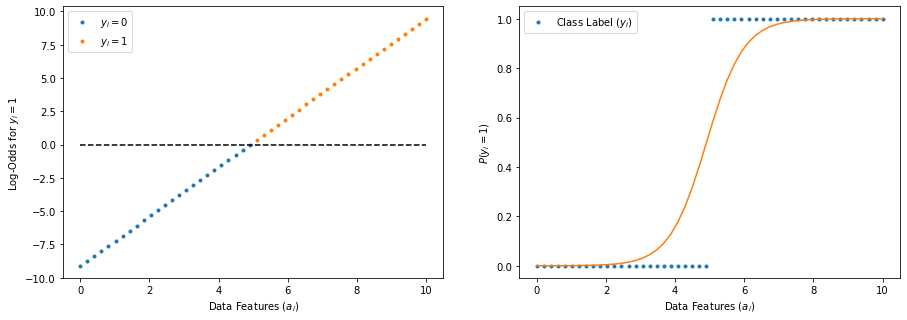

In [2]:
noise_level = 0; inlier_pct = 1.0 # modify these variables

# Generate data
n = 50
x = np.array([-10, 2])
A = np.array([np.ones(n), np.linspace(0, 10, n)]).T
p = lambda a: 1/(1 + np.exp(-(2*a - 10)))
np.random.seed(0)
y = np.array([0 if p(ii) + noise_level*np.random.standard_t(1) < 0.5 else 1 for ii in A[:, 1]])

# Create model
training_data = utils.ImageData(A, (2,), labels=y)
model = utils.BinaryLogisticRegression(training_data, lam=0.001, inlier_pct=inlier_pct)
classifier, outliers = model.fit_model()
x = classifier.classifier
if inlier_pct < 1:
    a2 = np.array([a[1] for a in outliers.images])
    y2 = np.array([0 if y == -1 else 1 for y in outliers.labels])
utils.print_blr(A, y, x, 'training')
print(f'True x: {[-10, 2]}, Classifier: {x}')
utils.plot_blr(A[:, 1], y, x, outliers)

# Exercise 2: MNIST

The [MNIST](http://yann.lecun.com/exdb/mnist/) data set contains images of handwritten digits.
Each image is 28x28 pixels, which we reshape into feature vectors $a_i \in \mathbf{R}^{784}$.
For our examples, we will consider a subset of 1000 training images and 200 test images that contain zeros and ones, and our goal will be to build a classifier to correctly predict whether a given image contains a zero or a one.

Number of training images: 1000
Number of testing images: 200


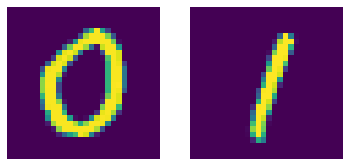

In [3]:
# Load data
A_train = np.load('../data/train_images.npy')
y_train = np.load('../data/train_labels.npy')
A_test = np.load('../data/test_images.npy')
y_test = np.load('../data/test_labels.npy')
print(f'Number of training images: {y_train.size}')
print(f'Number of testing images: {y_test.size}')

# Show two examples
fig, ax = plt.subplots(1, 2)
ax[0].imshow(A_train[1].reshape(28, 28))
ax[0].axis('off')
ax[1].imshow(A_test[2].reshape(28, 28))
ax[1].axis('off');

We will build a classifier for the MNIST 0-1 images using logistic regression with 2-norm regularization by solving the problem

$$\min_x \sum_{i=1}^m \log\big( 1 + \exp(a_i^Tx) \big) - y_i a_i^T x + \frac{\lambda}{2} \| x \|_2^2,$$

where $a_i \in \mathbf{R}^{784}$, $y_i \in \{0, 1\}$, and $x \in \mathbf{R}^{784}$.
Once we have solved for $x$, we can classify an image as a zero or a one based on the sign of $a_i^Tx$.

Maximum number of iterations reached: 1000.
Minimum function value: 8.32
Total time: 2.99 secs
Correctly classified in training set: 999/1000
Correctly classified in test set: 200/200


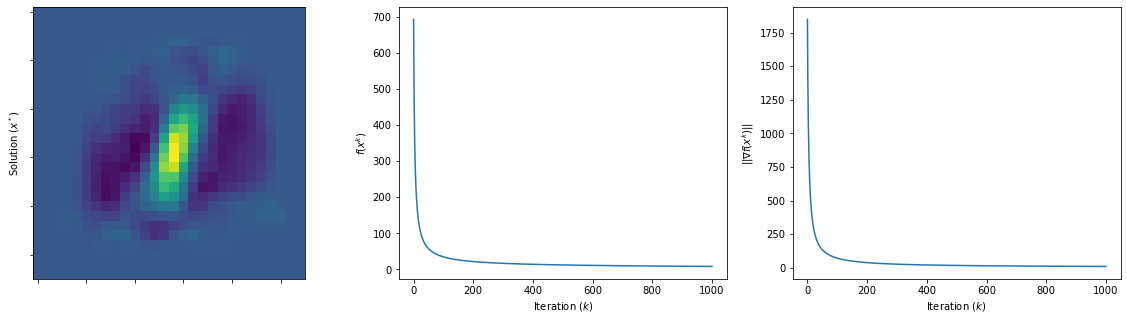

In [4]:
lam = 0.1
step = 1/(np.linalg.norm(A_train)**2/4 + lam)
def func(x):
    z = A_train.dot(x)
    return np.sum(np.log(1 + np.exp(z)) - y_train*z) + lam*np.sum(x**2)/2
def grad(x):
    z = A_train.dot(x)
    return A_train.T.dot(np.exp(z)/(1 + np.exp(z)) - y_train) + lam*x
results = utils.gradient_descent(func, grad, step=step, x0=np.zeros_like(A_train[0]))
utils.print_blr(A_train, y_train, results[0], 'training')
utils.print_blr(A_test, y_test, results[0], 'test')
utils.plot_mnist(results)

Below, we see our solution vector $x^*$ reshaped into a 28x28 image.
To produce negative values for images containing a zero, the classifier is negative in regions where the zero images are likely to be positive.
Likewise, to produce positive values for images containing ones, the classifier is positive in regions where one images are likely to be positive.

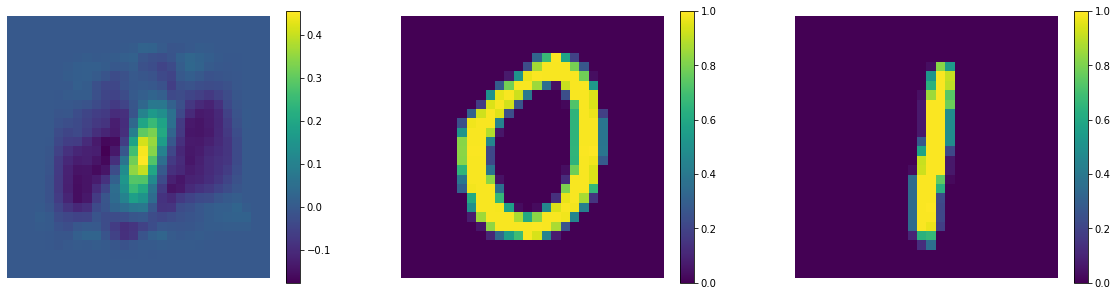

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
f0 = ax[0].imshow(results[0].reshape(28, 28))
ax[0].axis('off')
fig.colorbar(f0, ax=ax[0])
f1 = ax[1].imshow(A_train[1].reshape(28, 28))
ax[1].axis('off')
fig.colorbar(f1, ax=ax[1])
f2 = ax[2].imshow(A_train[2].reshape(28, 28))
ax[2].axis('off')
fig.colorbar(f2, ax=ax[2]);

Using this classifier, we were able to correctly classify almost every image in the training and test data sets.
So what about the one image we could not correctly classify?
Below, we see that while this image contains a zero, it is much narrower than the negative regions in the classifier.
Let's see if we can use trimming for our regularized logistic regression model to identify other images that don't quite fit within the typical zero or one images.

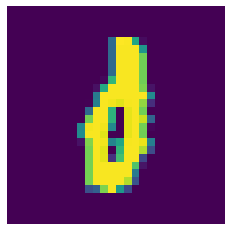

In [6]:
p_train = 1.0*(A_train.dot(results[0]) >= 0)
plt.imshow(A_train[p_train != y_train].reshape(28, 28))
plt.axis('off');

In the example below, experiment with the inlier_pct variable to answer the following questions:
* How does the number of outliers trimmed affect the number of correctly classified images in the training and test sets?
* How does the number of outliers trimmed affect the shape of the classifier?
* Looking at a sample of the outliers, can you guess why these images were trimmed?

Correctly classified in train set: 998/1000
Correctly classified in test set: 200/200


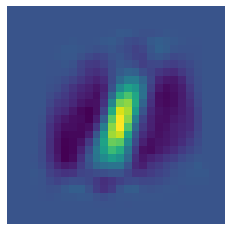

In [7]:
inlier_pct = 1.0 # modify this variable

# Get classifier
training_data = utils.ImageData(A_train, (28, 28), labels=y_train)
testing_data = utils.ImageData(A_test, (28,28), labels=y_test)
model = utils.BinaryLogisticRegression(training_data, lam=0.1, inlier_pct=inlier_pct)
classifier, outliers = model.fit_model()
utils.print_blr(A_train, y_train, classifier.classifier, 'train')
utils.print_blr(A_test, y_test, classifier.classifier, 'test')
classifier.plot_classifier()

# Plot outliers
k = 5
if outliers is not None:
    print(f'Number of outlier images: {outliers.num_images}')
    print(f'Number of \"0\" outlier images: {outliers.class_sizes[0]}')
    print(f'Number of \"1\" outlier images: {outliers.class_sizes[1]}')
    if outliers.num_images >= 2*k:
        fig, ax = plt.subplots(2, k, figsize=(15, 5))
        idx0 = np.argwhere(outliers.labels == -1)
        idx1 = np.argwhere(outliers.labels == 1)
        for ii in range(k):
            ax[0, ii].imshow(outliers.images[idx0[ii]].reshape(28, 28))
            ax[0, ii].axis('off')
            ax[1, ii].imshow(outliers.images[idx1[ii]].reshape(28, 28))
            ax[1, ii].axis('off')

# Further Reading
* Rousseeuw, P. J. (1985). "Multivariate estimation with high breakdown point." *Mathematical Statistics and Applications*, 8(283-297), 37.
* Neykov, N. M., & Müller, C. H. (2003). "Breakdown point and computation of trimmed likelihood estimators in generalized linear models." In *Developments in Robust Statistics* (pp. 277-286). Physica, Heidelberg.
* Yang, E., Lozano, A. C., & Aravkin, A. (2018). "A general family of trimmed estimators for robust high-dimensional data analysis." *Electronic Journal of Statistics*, 12(2), 3519-3553.
* Aravkin, A., & Davis, D. (2020). "Trimmed statistical estimation via variance reduction." *Mathematics of Operations Research*, 45(1), 292-322.